# NAO example notebook

This notebook contains an example of data access on wilma (CNR) machine of ERA5 and evaluation of the NAO teleconnection (station based index) with aqua libraries and an example of the plotting routines.

In [1]:
import cftime
import dask
import datetime
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from index import *
from plots import *
from tools import *

#sys.path.insert(1, '/work/bb1153/b382289/AQUA/')
sys.path.insert(1, '../../')
from aqua import Reader

## Teleconnection and machine details configuration

Details such as teleconnection coordinates, folder input/output are obtained with functions collected in the `tools.py` file, that access details from a `yaml` file.
Machine and diagnostic needs to be specified.
Details about the NAO teleconnection can be accessed by specificing the teleconnection name as a string.

In [2]:
machine   = 'wilma'
diagname  = 'teleconnections'
telecname = 'ENSO'

config   = load_config(machine)
namelist = load_namelist(diagname)

`config` and `namelist` contain now the detail about the machine and the teleconnections diagnostic.

## Retrieve data with the intake AQUA functionality

In [4]:
configdir = '../../config/'

reader = Reader(model='IFS', exp='tco2559-ng5', source='lra_r100',configdir=configdir)

In [5]:
data = reader.retrieve(fix=False)
data

<xarray.Dataset>
Dimensions:  (time: 13, lat: 180, lon: 360)
Coordinates:
  * time     (time) int64 0 29 60 90 121 151 182 213 243 274 304 335 366
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Data variables:
    2t       (time, lat, lon) float64 dask.array<chunksize=(13, 180, 360), meta=np.ndarray>
    msl      (time, lat, lon) float64 dask.array<chunksize=(13, 180, 360), meta=np.ndarray>
    tp       (time, lat, lon) float64 dask.array<chunksize=(13, 180, 360), meta=np.ndarray>

In [6]:
infile = data['2t']
infile

<xarray.DataArray '2t' (time: 13, lat: 180, lon: 360)>
dask.array<open_dataset-768794d5dc5ba5e7b4a141ef715672232t, shape=(13, 180, 360), dtype=float64, chunksize=(13, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 29 60 90 121 151 182 213 243 274 304 335 366
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Attributes: (12/15)
    paramId:                    167
    dataType:                   fc
    numberOfPoints:             26306560
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    name:                       2 metre temperature
    cfVarName:                  t2m
    missingValue:               9999
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Gaussian Latitude/Longitude Grid

In [7]:
enso = regional_mean_index(infile,namelist,telecname,months_window=1)

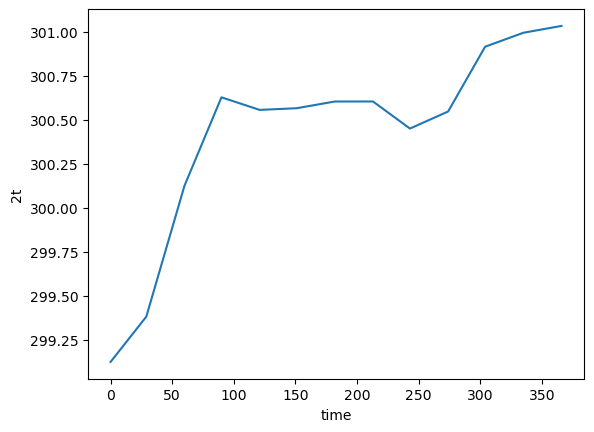

In [8]:
enso.plot()

## Regression plot

To visualize the teleconnection on a 2D plot functions in the `plots.py` are introduced.
There is an option `plot=True` that creates a plot of the regression. Additionally an xarray containing the result of the regression is returned.

<xarray.DataArray '2t' (lat: 180, lon: 360)>
dask.array<truediv, shape=(180, 360), dtype=float64, chunksize=(180, 360), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0

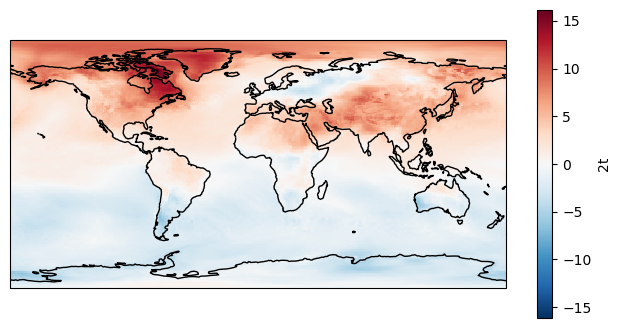

In [9]:
reg_plot(enso,infile)